# Import 

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.algos.parameter_space import ParameterSpace

from gemseo import to_pickle
from gemseo.disciplines.surrogate import SurrogateDiscipline
from lh2pac.utils import update_default_inputs

import pandas as pd

configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [3]:
update_default_inputs(disciplines, {"slst": 102553.5797633953, "n_pax":120, "area":113.9439805972377, "ar":13.75744220738756})
disciplines[0].io.input_grammar.defaults

{'area': 113.9439805972377, 'ar': 13.75744220738756, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [4]:
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

# Split train/test dataset

In [5]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)
test_dataset = sample_disciplines(disciplines, uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=20)

    INFO - 15:28:28: *** Start Sampling execution ***
    INFO - 15:28:28: Sampling
    INFO - 15:28:28:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:28:28:    MDO formulation: MDF
    INFO - 15:28:28: Running the algorithm OT_OPT_LHS:
    INFO - 15:28:28:    100%|██████████| 20/20 [00:00<00:00, 332.11 it/sec]
    INFO - 15:28:28: *** End Sampling execution (time: 0:00:00.065371) ***
    INFO - 15:28:28: *** Start Sampling execution ***
    INFO - 15:28:28: Sampling
    INFO - 15:28:28:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:28:28:    MDO formulation: MDF
    INFO - 15:28:28: Running the algorithm OT_MONTE_CARLO:
    INFO - 15:28:28:    100%|██████████| 20/20 [00:00<00:00, 406.72 it/sec]
    INFO - 15:28:28: *** End Sampling execution (time: 0:00:00.051733) ***


# Try different surrogates

 Testing surrogate: RBF_gaussian
 Testing surrogate: RBF_gaussian_mg
 Testing surrogate: Polynomial_deg2
 Testing surrogate: Polynomial_deg3

Résultats comparatifs :
                     fm  length    mtom  span    tofl    vapp      vz
Model                                                                
RBF_gaussian     0.8726     1.0  0.8337   1.0  0.8331  0.7808  0.8604
RBF_gaussian_mg  0.9938     1.0  0.9939   1.0  0.9939  0.9917  0.9951
Polynomial_deg2  1.0000     1.0  1.0000   1.0  1.0000  1.0000  1.0000
Polynomial_deg3  1.0000     1.0  1.0000   1.0  1.0000  1.0000  1.0000


<Figure size 1200x600 with 0 Axes>

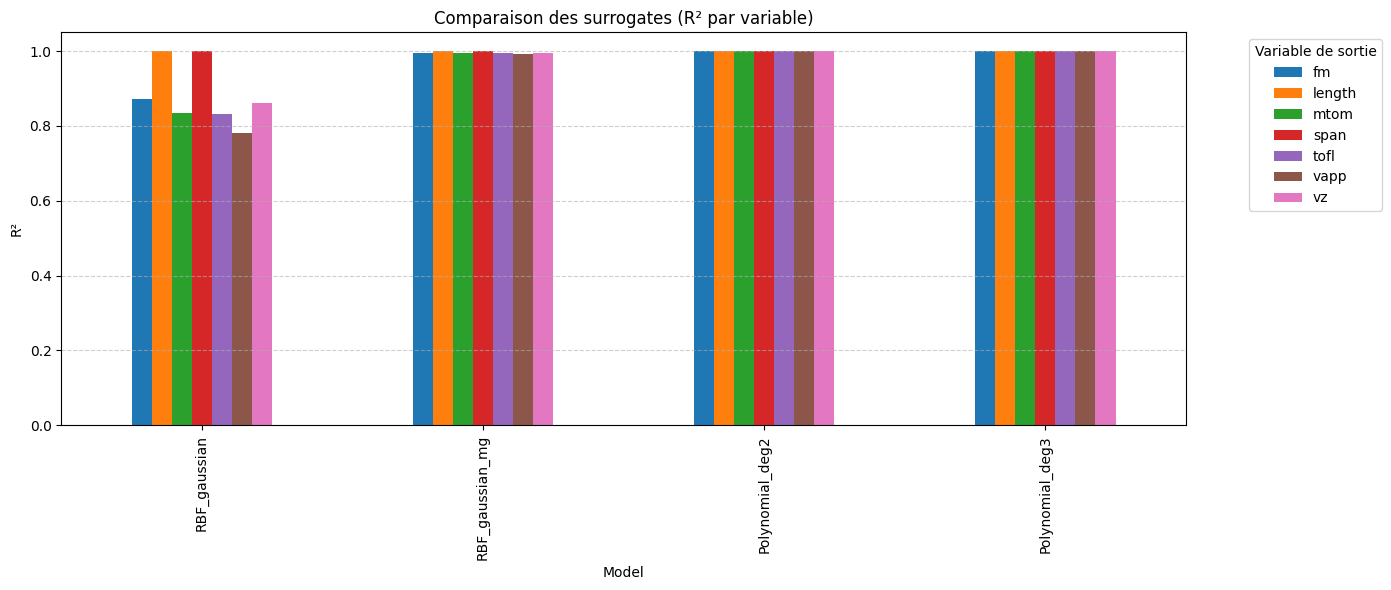

In [7]:
surrogate_configs = [
    {"name": "RBF_gaussian", "model": "RBFRegressor", "function": "gaussian"},
    {"name": "RBF_gaussian_mg", "model": "RBFRegressor", "function": "multiquadric"},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 2},
    {"name": "Polynomial_deg3", "model": "PolynomialRegressor", "degree": 3},
]

results = []

for config in surrogate_configs:
    name = config["name"]
    model_type = config["model"]
    kwargs = {k: v for k, v in config.items() if k not in ["name", "model"]}

    print(f" Testing surrogate: {name}")
    
    surrogate = SurrogateDiscipline(model_type, data=training_dataset, **kwargs)
    r2 = surrogate.get_error_measure("R2Measure")
    test_scores = r2.compute_test_measure(test_dataset, as_dict=True)
    
    flat_scores = {key: float(value) for key, value in test_scores.items()}
    flat_scores["Model"] = name
    results.append(flat_scores)

df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
print("\nRésultats comparatifs :")
print(df_results.round(4)
)
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(14, 6))
plt.title("Comparaison des surrogates (R² par variable)")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Variable de sortie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save best surrogate

In [8]:
surrogate_discipline = SurrogateDiscipline("PolynomialRegressor", degree = 2, data = training_dataset)

In [9]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([1.84789937e-06]),
 'length': array([0.]),
 'mtom': array([0.00132797]),
 'span': array([0.]),
 'tofl': array([0.00016938]),
 'vapp': array([8.94700669e-07]),
 'vz': array([3.64673206e-06])}

In [11]:
to_pickle(surrogate_discipline, "UC1_my_surrogate_2.pkl")